---



* 작성자: 한양대ERICA, 산업경영공학과, 김윤성
* 마지막 수정일: 2023.06.06


---

# (1) Preliminaries

In [1]:
from google.colab import drive
from google.colab import files

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Image

import random

import torch
import torch.nn as nn

import time

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import torchvision

import cv2

# (2) Load the dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("학습 데이터셋 A의 개수:", len(next(os.walk('/content/drive/MyDrive/데이터/edges2portrait/trainA'))[2]))
print("학습 데이터셋 B의 개수:", len(next(os.walk('/content/drive/MyDrive/데이터/edges2portrait/trainB'))[2]))

학습 데이터셋 A의 개수: 3168
학습 데이터셋 B의 개수: 3168


이미지 크기: (256, 256)


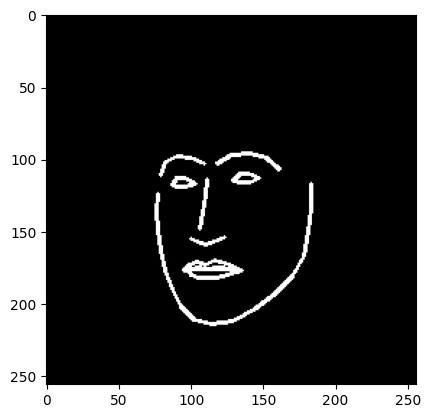

In [ ]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('/content/drive/MyDrive/데이터/edges2portrait/trainA/10422182074_b778e041d7_c.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

이미지 크기: (256, 256)


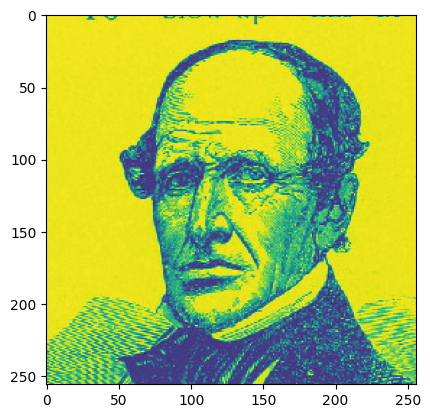

In [ ]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('/content/drive/MyDrive/데이터/edges2portrait/trainB/10422182074_b778e041d7_c.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

# (3) Data Preprocessing

In [ ]:
# 데이터셋 폴더 경로
dataset_path = "/content/drive/MyDrive/데이터/edges2portrait/"

# 이미지 크기
image_size = (256, 256)

# trainA 폴더의 이미지 읽어오기
trainA_path = os.path.join(dataset_path, "trainA")
trainA_images = sorted(os.listdir(trainA_path))

# trainB 폴더의 이미지 읽어오기
trainB_path = os.path.join(dataset_path, "trainB")
trainB_images = sorted(os.listdir(trainB_path))

# 이미지 합치기 및 저장
for i, (imageA, imageB) in enumerate(zip(trainA_images, trainB_images), 1):
    imageA_path = os.path.join(trainA_path, imageA)
    imageB_path = os.path.join(trainB_path, imageB)

    imageA = Image.open(imageA_path).resize(image_size)
    imageB = Image.open(imageB_path).resize(image_size)

    combined_image = Image.new("RGB", (512, 256))
    combined_image.paste(imageA, (0, 0))
    combined_image.paste(imageB, (256, 0))

    # 합쳐진 이미지 저장
    save_path = os.path.join(dataset_path, "combine_image", f"{i}.jpg")
    combined_image.save(save_path)

이미지 크기: (512, 256)


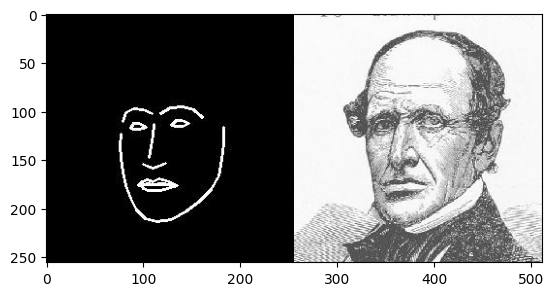

In [ ]:
# 한 쌍의 이미지 출력(왼쪽은 정답 이미지, 오른쪽은 조건 이미지)
image = Image.open('/content/drive/MyDrive/데이터/edges2portrait/combine_image/test/1.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

In [10]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_
        self.target_size = (512, 256)  # 원하는 이미지 크기
        self.scale_range = (0.8, 1.2)  # 확대/축소 범위

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.jpg"))
        # 데이터의 개수가 적기 때문에 테스트 데이터를 학습 시기에 사용
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.jpg")))

    def augment_resize(self, image):
        scale_factor = random.uniform(self.scale_range[0], self.scale_range[1])
        new_width = int(self.target_size[0] * scale_factor)
        new_height = int(self.target_size[1] * scale_factor)
        resized_image = image.resize((new_width, new_height))
        left = (new_width - self.target_size[0]) // 2
        top = (new_height - self.target_size[1]) // 2
        cropped_image = resized_image.crop((left, top, left + self.target_size[0], top + self.target_size[1]))
        return cropped_image

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반
        img_B = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반

        # 데이터 증진(data augmentation)을 위한 좌우 반전(horizontal flip)
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.augment_resize(img_A)
        img_B = self.augment_resize(img_B)

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [11]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("/content/drive/MyDrive/데이터/edges2portrait/combine_image", transforms_=transforms_)
val_dataset = ImageDataset("/content/drive/MyDrive/데이터/edges2portrait/combine_image", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# (4) Build the model

## Residual Connections레이어 모델 -> 성능이 더 안좋게 나옴

In [ ]:
# # Residual Connection을 추가하는 코드
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.relu = nn.ReLU(inplace=True)
        
#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out += residual  # 잔차 연결
#         out = self.relu(out)
#         return out

# # U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
# class UNetDown(nn.Module):
#     def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
#         super(UNetDown, self).__init__()
#         # 너비와 높이가 2배씩 감소
#         layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
#                   nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#                   ]
#         if normalize:
#             layers.append(nn.InstanceNorm2d(out_channels))
#         layers.append(nn.LeakyReLU(0.2))
#         if dropout:
#             layers.append(nn.Dropout(dropout))
#         self.model = nn.Sequential(*layers)

#         # Residual Block 추가
#         self.residual_block = ResidualBlock(out_channels, out_channels)

#     def forward(self, x):
#         x = self.model(x)
#         x = self.residual_block(x)  # 잔차 연결
#         return x

# # U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
# class UNetUp(nn.Module):
#     def __init__(self, in_channels, out_channels, dropout=0.0):
#         super(UNetUp, self).__init__()
#         # 너비와 높이가 2배씩 증가
#         layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
#                   nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#                   ]
#         layers.append(nn.InstanceNorm2d(out_channels))
#         layers.append(nn.ReLU(inplace=True))
#         if dropout:
#             layers.append(nn.Dropout(dropout))
#         self.model = nn.Sequential(*layers)

#         # Residual Block 추가
#         self.residual_block = ResidualBlock(out_channels, out_channels)

#     def forward(self, x, skip_input):
#         x = self.model(x)
#         x = self.residual_block(x)
#         x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

#         return x


# # U-Net 생성자(Generator) 아키텍처
# class GeneratorUNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3):
#         super(GeneratorUNet, self).__init__()

#         self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
#         self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
#         self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
#         self.down4 = UNetDown(256, 512, dropout=0.4) # 출력: [512 X 16 X 16]
#         self.down5 = UNetDown(512, 512, dropout=0.4) # 출력: [512 X 8 X 8]
#         self.down6 = UNetDown(512, 512, dropout=0.4) # 출력: [512 X 4 X 4]
#         self.down7 = UNetDown(512, 512, dropout=0.4) # 출력: [512 X 2 X 2]
#         self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

#         # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
#         self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
#         self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
#         self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
#         self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
#         self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
#         self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
#         self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

#         self.final = nn.Sequential(
#             nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
#             nn.ZeroPad2d((1, 0, 1, 0)),
#             nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
#         d1 = self.down1(x)
#         d2 = self.down2(d1)
#         d3 = self.down3(d2)
#         d4 = self.down4(d3)
#         d5 = self.down5(d4)
#         d6 = self.down6(d5)
#         d7 = self.down7(d6)
#         d8 = self.down8(d7)
#         u1 = self.up1(d8, d7)
#         u2 = self.up2(u1, d6)
#         u3 = self.up3(u2, d5)
#         u4 = self.up4(u3, d4)
#         u5 = self.up5(u4, d3)
#         u6 = self.up6(u5, d2)
#         u7 = self.up7(u6, d1)

#         return self.final(u7)


# # U-Net 판별자(Discriminator) 아키텍처
# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_channels, out_channels, normalization=True):
#             # 너비와 높이가 2배씩 감소
#             layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#                       nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#                       ]
#             if normalization:
#                 layers.append(nn.InstanceNorm2d(out_channels))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
#             *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
#             *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
#             *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
#             *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
#             nn.ZeroPad2d((1, 0, 1, 0)),
#             nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
#         )

#     # img_A: 실제/변환된 이미지, img_B: 조건(condition)
#     def forward(self, img_A, img_B):
#         # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
#         img_input = torch.cat((img_A, img_B), 1)
#         return self.model(img_input)

## Conv2d 레이어 모델

In [13]:
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# (5) Training

In [ ]:
n_epochs = 95 # 학습의 횟수(epoch) 설정
sample_interval = 200 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, '/content/drive/MyDrive/데이터/edges2portrait/result2/' + f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/95] [D loss: 0.151781] [G pixel loss: 0.344377, adv loss: 0.35021406412124634] [Elapsed time: 542.16s]
[Epoch 1/95] [D loss: 0.042183] [G pixel loss: 0.291153, adv loss: 0.9544179439544678] [Elapsed time: 665.34s]
[Epoch 2/95] [D loss: 0.034174] [G pixel loss: 0.378209, adv loss: 0.9287824630737305] [Elapsed time: 788.39s]
[Epoch 3/95] [D loss: 0.034674] [G pixel loss: 0.266967, adv loss: 0.8598083257675171] [Elapsed time: 911.29s]
[Epoch 4/95] [D loss: 0.057721] [G pixel loss: 0.316218, adv loss: 0.8223535418510437] [Elapsed time: 1033.71s]
[Epoch 5/95] [D loss: 0.076462] [G pixel loss: 0.263052, adv loss: 0.8268551230430603] [Elapsed time: 1157.63s]
[Epoch 6/95] [D loss: 0.038265] [G pixel loss: 0.269046, adv loss: 1.0150744915008545] [Elapsed time: 1280.96s]
[Epoch 7/95] [D loss: 0.022382] [G pixel loss: 0.395241, adv loss: 1.0719778537750244] [Elapsed time: 1402.98s]
[Epoch 8/95] [D loss: 0.012261] [G pixel loss: 0.276072, adv loss: 0.8281750679016113] [Elapsed time: 1526.

In [ ]:
# 모델 파라미터 저장
torch.save(generator.state_dict(), "Pix2Pix_Generator.pt")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator.pt")
print("Model saved!")

Model saved!


In [ ]:
# 모델 파라미터 다운로드
files.download('Pix2Pix_Generator.pt')
files.download('Pix2Pix_Discriminator.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

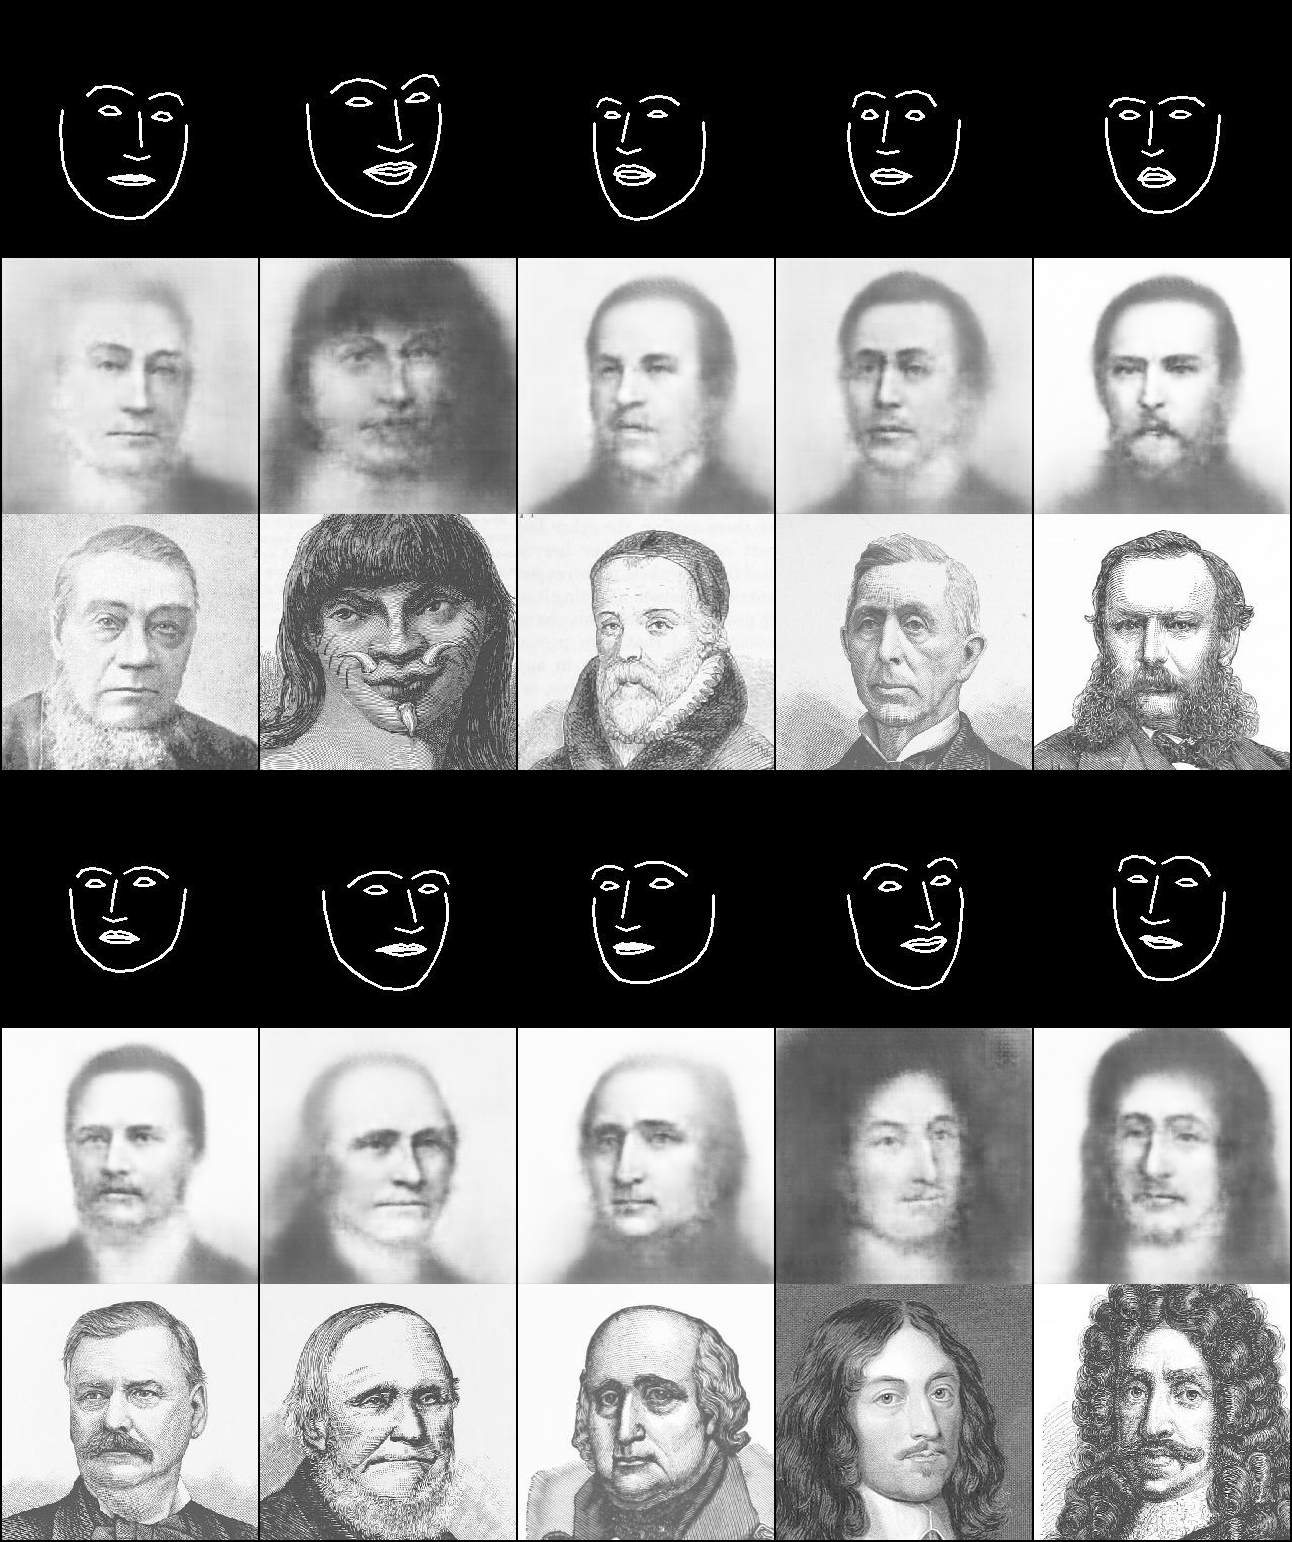

In [54]:
Image('/content/drive/MyDrive/데이터/edges2portrait/result2/30000.png')

# (6) Re-Training

- GPU 문제로 나눠서 학습

In [ ]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("/content/drive/MyDrive/데이터/edges2portrait/Pix2Pix_Generator.pt"))
discriminator.load_state_dict(torch.load("/content/drive/MyDrive/데이터/edges2portrait/Pix2Pix_Discriminator.pt"))

generator.eval();
discriminator.eval();

In [ ]:
imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
real_A = imgs["B"].cuda()
real_B = imgs["A"].cuda()
fake_B = generator(real_A)
# real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
save_image(img_sample, '/content/drive/MyDrive/데이터/edges2portrait/result2/' + f"result.png", nrow=5, normalize=True)

In [ ]:
# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
n_epochs = 50 # 학습의 횟수(epoch) 설정
sample_interval = 200 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, '/content/drive/MyDrive/데이터/edges2portrait/result2_plus/' + f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/50] [D loss: 0.002746] [G pixel loss: 0.186309, adv loss: 1.010608196258545] [Elapsed time: 126.71s]
[Epoch 1/50] [D loss: 0.000880] [G pixel loss: 0.169974, adv loss: 0.9926735162734985] [Elapsed time: 257.03s]
[Epoch 2/50] [D loss: 0.000486] [G pixel loss: 0.193531, adv loss: 0.9879395961761475] [Elapsed time: 386.37s]
[Epoch 3/50] [D loss: 0.005650] [G pixel loss: 0.181916, adv loss: 0.9645466804504395] [Elapsed time: 516.28s]
[Epoch 4/50] [D loss: 0.000525] [G pixel loss: 0.179380, adv loss: 1.0154988765716553] [Elapsed time: 645.46s]
[Epoch 5/50] [D loss: 0.000368] [G pixel loss: 0.181382, adv loss: 0.9971170425415039] [Elapsed time: 775.67s]
[Epoch 6/50] [D loss: 0.000712] [G pixel loss: 0.179622, adv loss: 0.9912935495376587] [Elapsed time: 905.64s]
[Epoch 7/50] [D loss: 0.000369] [G pixel loss: 0.174606, adv loss: 1.0095641613006592] [Elapsed time: 1035.40s]
[Epoch 8/50] [D loss: 0.000661] [G pixel loss: 0.166204, adv loss: 1.0037622451782227] [Elapsed time: 1165.91s]


In [ ]:
# 모델 파라미터 저장
torch.save(generator.state_dict(), "Pix2Pix_Generator2.pt")
torch.save(discriminator.state_dict(), "Pix2Pix_Discriminator2.pt")
print("Model saved!")

Model saved!


In [ ]:
# 모델 파라미터 다운로드
files.download('Pix2Pix_Generator2.pt')
files.download('Pix2Pix_Discriminator2.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (7) Evaluation

- 생성된 마지막 이미지 OpenCV의 얼굴 감지 모듈로 학습 잘되었는지 확인

In [ ]:
# 얼굴 감지 모델 들고오기
!git clone https://github.com/kairess/edges2portrait_gan.git

Cloning into 'edges2portrait_gan'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 2.77 MiB | 10.38 MiB/s, done.


In [ ]:
facenet = cv2.dnn.readNetFromTensorflow(
  '/content/edges2portrait_gan/face_models/opencv_face_detector_uint8.pb',
  '/content/edges2portrait_gan/face_models/opencv_face_detector.pbtxt'
)

model_path = '/content/edges2portrait_gan/face_models/landmarks_net.pb'
net = cv2.dnn.readNetFromTensorflow(model_path)

IMG_SIZE = 192
FACE_THRESHOLD = 0.7

In [27]:
img = cv2.imread('/content/drive/MyDrive/데이터/edges2portrait/result2/29600.png', cv2.IMREAD_COLOR)

img_result = img.copy()

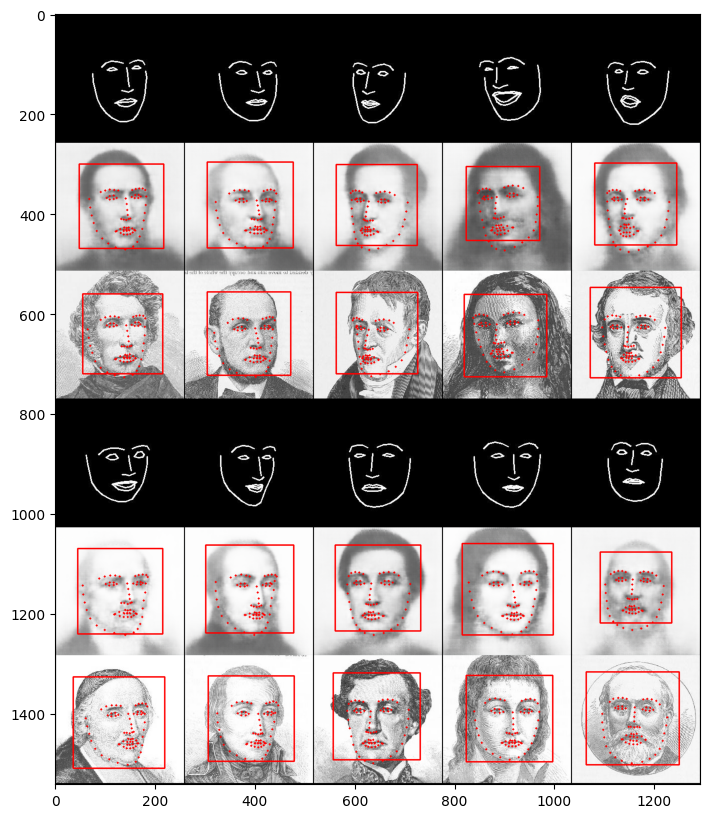

In [28]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300, 300), mean=[104, 117, 123], swapRB=False, crop=False)

facenet.setInput(blob)
dets = facenet.forward()

for i in range(dets.shape[2]):
    conf = dets[0, 0, i, 2]

    if conf < FACE_THRESHOLD:
        continue

    x1 = dets[0, 0, i, 3] * img.shape[1]
    y1 = dets[0, 0, i, 4] * img.shape[0]
    x2 = dets[0, 0, i, 5] * img.shape[1]
    y2 = dets[0, 0, i, 6] * img.shape[0]
    
    face_length = max(x2 - x1, y2 - y1)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    sx1 = int(cx - face_length / 2)
    sx2 = int(cx + face_length / 2)
    sy1 = int(cy - face_length / 2)
    sy2 = int(cy + face_length / 2)
    
    cv2.rectangle(img_result, pt1=(int(sx1), int(sy1)), pt2=(int(sx2), int(sy2)), thickness=2, color=(255,0,0))
    
    face_img = img[sy1:sy2, sx1:sx2]
    fh, fw, _ = face_img.shape
    face_img = cv2.resize(face_img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_img = face_img.astype(np.float32)
    face_img = cv2.normalize(face_img, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    face_img = face_img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    face_img_cv = np.transpose(face_img, (0, 3, 1, 2))
    
    net.setInput(face_img_cv)
    contours, pose = net.forward(['contour/contour_tf', 'pose/pose_tf'])
    
    for i, p in enumerate(contours.reshape((-1, 2))):
        sp = (p * [fw, fh] / IMG_SIZE) + [sx1, sy1]

        cv2.circle(img_result, center=tuple(sp.astype(int)), radius=2, color=(255, 0, 0), thickness=-1)

plt.figure(figsize=(10, 10))
plt.imshow(img_result)

- 그림판에서 256*256의 얼굴을 그린후 넣고 학습이 잘되었는지 확인

In [14]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("/content/drive/MyDrive/데이터/edges2portrait/Pix2Pix_Generator2.pt"))
discriminator.load_state_dict(torch.load("/content/drive/MyDrive/데이터/edges2portrait/Pix2Pix_Discriminator2.pt"))

generator.eval();
discriminator.eval();

In [15]:
imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
real_A = imgs["B"].cuda()
real_B = imgs["A"].cuda()
fake_B = generator(real_A)
# real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
save_image(img_sample, '/content/drive/MyDrive/데이터/edges2portrait/result2/' + f"result.png", nrow=5, normalize=True)

In [16]:
# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [51]:
# 테스트 입력 이미지 경로
input_image_path = "/content/test4.jpg"

# 입력 이미지 로드
input_image = Image.open(input_image_path).convert("RGB")

# 이미지 변환 및 정규화
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 입력 이미지 변환
input_tensor = transform(input_image).unsqueeze(0).cuda()

# 이미지 생성
with torch.no_grad():
    generated_image = generator(input_tensor)

# 이미지 저장
save_path = "generated_image.png"
torchvision.utils.save_image(generated_image, save_path)

print("이미지를 저장했습니다:", save_path)


이미지를 저장했습니다: generated_image.png


In [52]:
# test1.png와 generated_image.png를 불러옴
test_image = Image.open(input_image_path)
generated_image = Image.open('generated_image.png')

# 두 이미지를 가로로 붙이기
result_image = Image.new('RGB', (test_image.width + generated_image.width, max(test_image.height, generated_image.height)))
result_image.paste(test_image, (0, 0))
result_image.paste(generated_image, (test_image.width, 0))

# 결과 이미지 저장
result_image.save('combined_image.png')

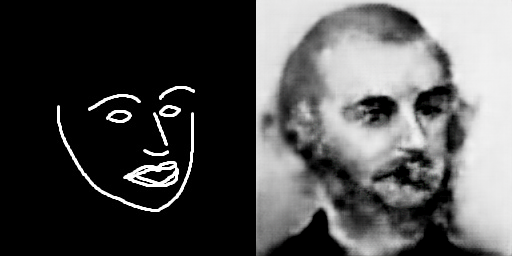

In [53]:
Image('combined_image.png')